# Прогнозирование цены автомобиля


<b>Постановка задачи:</b>  
Практика покупки и продажи поддержанных автомобилей широко распростронена в современном мире и одной из главной проблем данной практики - это оценка стоимости автомобиля, так как на стоимость влияют много различных факторов, такие как: состояние, год выпуска, пробен, а также внутренние характеристики автомобиля. А так как оценка стоимости происходит владельцами, то часто происходят ситуации с сильным завышением цен. Данный проект направлен на создание модели для оценки стоимости поддержанных автомобилей, которая поможет как и покупателям - не переплачивать за желаемую технику, так и продавцам - быстро устанавливать рыночную цену, без дополнительных трат на оценку стоимости.

<br>

<b>Исходные данные</b>
Исходные данные для работы взяты из открытого доступа ресурса kaggle
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

<br>

## Установка датасета с kaggle
Для установки с kaggle используется специальный API токен kaggle.json

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dievisconti","key":"28fd0ae6209e5708bf6572ebb762657a"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data

craigslist-carstrucks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('craigslist-carstrucks-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Подготовка данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/content/vehicles.csv')
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


### Рассмотрим признаки данного датасета

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

Имеются следующие признаки


*  id - идентификатор записи
*  url - ссылка на обьявление
*  region - регион на Craiglist
*  region_url - ссылка на регион Craiglist
*  price - стоимость (в долларах)
*  year - год выпуска транспортного средства
*  manufacturer - производитель
*  model - модель транспортного средства
*  condition - состояние транспортного средства
*  cyclinders - число целиндров
*  fuel - используемое топливо
*  odometer - пробег (кол-во миль, пройденных автомобилем)
*  title_status - тип статуса транспортного средства
*  transmission - тип трансмисии
*  VIN - Идентификационный номер транспортного средства — уникальный код транспортного средства, состоящий из 17 знаков. В коде представлены сведения о производителе и характеристиках транспортного средства, а также о годе выпуска
*  drive - тип привода
*  size - размер транспортного средства
*  type - общий тип транспортного средства
*  paint_color - цвет транспортного средства
*  image_url - ссылка на изображение с автомобилем
*  description - описание
*  county - округ (примечание автора датасета: бесполезный столбец оставлен по ошибке)
*  state - штат, где находится транспортной средство
*  lat - географическая широта обьявления
*  long - географическая долгота обьявления
*  posting_date - дата публикации обьявления

### Посчитаем процент пропущенных значений признаков

In [9]:
clear_df = df.copy()
(clear_df.isna().sum() / len(clear_df)).round(4) * 100

id                0.00
url               0.00
region            0.00
region_url        0.00
price             0.00
year              0.28
manufacturer      4.13
model             1.24
condition        40.79
cylinders        41.62
fuel              0.71
odometer          1.03
title_status      1.93
transmission      0.60
VIN              37.73
drive            30.59
size             71.77
type             21.75
paint_color      30.50
image_url         0.02
description       0.02
county          100.00
state             0.00
lat               1.53
long              1.53
posting_date      0.02
dtype: float64

Признак county не имеет ненулевых значений, а признак size имеет около 70% нулевых, поэтому отбросим данные признаки.

In [10]:
clear_df = clear_df.drop(['county', 'size'], axis=1)

Признаки year, odometer, manufacturer, model, fuel, transmission имееют меньше 5 процентов нулевых значений. Избавимся от строк которые, содержат пропуски во всех этих признаках

In [11]:
clear_df = clear_df.dropna(subset=['year', 'odometer', 'manufacturer', 'model', 'fuel', 'transmission'])

Все остальные нулевые значения заполним категорией unknown

In [12]:
clear_df.fillna('unknown', inplace=True)

### Проанализируем типы признаков и какие значения они могут принимать



In [13]:
def describe(values, col_name):
    print("Признак", col_name)
    print("Значения: ", values[:20])
    print("Количество значений: ", len(values), '\n')

for col in clear_df.columns:
  if clear_df[col].dtype == object:
    describe(clear_df[col].unique(), col)


Признак url
Значения:  ['https://auburn.craigslist.org/ctd/d/auburn-university-2014-gmc-sierra-1500/7316814884.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2010-chevy-chevrolet/7316814758.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2020-chevy-chevrolet/7316814989.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2017-toyota-tundra/7316743432.html'
 'https://auburn.craigslist.org/cto/d/auburn-university-2013-150/7316356412.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2012-gmc-sierra-2500/7316343444.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2016-chevy-chevrolet/7316304717.html'
 'https://auburn.craigslist.org/cto/d/auburn-2019-tacoma-trd-offroad/7316285779.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2016-chevy-chevrolet/7316257769.html'
 'https://auburn.craigslist.org/ctd/d/auburn-university-2011-chevy-chevrolet/7316133914.html'
 'https://auburn.craigslist.org/cto/d/opelika-1992-jeep-che

Такие признаки как: region, url, region_url, image_url являются ссылками и не представляют интереса как целочисленный признак id и строковый VIN, поэтому отбросим их.



In [14]:
clear_df = clear_df.drop(['url', 'region_url', 'image_url', 'id', 'VIN'], axis=1)

Категориальные признаки state и region, а также численные lat, long- отображают местонахождение транспортного средства, ввиду большего количества регионов чем штатов, то отбросим признак state и координаты ввиду избыточности

In [15]:
clear_df = clear_df.drop(['state', 'lat', 'long'], axis=1)

In [16]:
for col in clear_df.columns:
  if clear_df[col].dtype == object:
    describe(clear_df[col].unique(), col)

Признак region
Значения:  ['auburn' 'birmingham' 'dothan' 'florence / muscle shoals'
 'gadsden-anniston' 'huntsville / decatur' 'mobile' 'montgomery'
 'tuscaloosa' 'anchorage / mat-su' 'fairbanks' 'kenai peninsula'
 'southeast alaska' 'flagstaff / sedona' 'mohave county' 'phoenix'
 'prescott' 'show low' 'sierra vista' 'tucson']
Количество значений:  404 

Признак manufacturer
Значения:  ['gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo']
Количество значений:  41 

Признак model
Значения:  ['sierra 1500 crew cab slt' 'silverado 1500' 'silverado 1500 crew'
 'tundra double cab sr' 'f-150 xlt' 'sierra 2500 hd extended cab'
 'silverado 1500 double' 'tacoma' 'colorado extended cab'
 'corvette grand sport' 'cherokee' 'wrangler unlimited sport'
 'silverado 1500 regular' 'colorado crew cab z71'
 'tacoma access cab pickup' 'camaro ss coupe 2d'
 'tundra crewmax sr5 picku

Признак posting_date - строковый тип, содержащий дату постинга обьявления в формате ISO.
</br>
Признак desсription - строковый тип, содержащий описание обьявления.
</br>

Признаки region, manufacturer, model, condition, cylinders, fuel, title_status, transmission, drive, size, type, paint_color, region - являются категориальными, содержащими от 4 до 404 возможных значений.
</br>
</br>


Так как количество возможно принимаемых значений у признаков model, manufacturer и region велико, то отберем определенное количество самых используемых для признака значений, остальные же вынесем как отдельную категорию

In [17]:
values = clear_df['manufacturer'].value_counts()
values

ford               68885
chevrolet          52997
toyota             33125
honda              20760
jeep               18510
nissan             18402
ram                17148
gmc                16208
bmw                14447
dodge              13190
mercedes-benz      11399
hyundai            10065
subaru              9308
volkswagen          9127
kia                 8254
lexus               8020
audi                7440
cadillac            6760
acura               5884
chrysler            5837
buick               5361
mazda               5316
infiniti            4722
lincoln             4104
volvo               3256
mitsubishi          3187
mini                2341
pontiac             2230
jaguar              1910
rover               1779
porsche             1319
mercury             1164
saturn              1057
alfa-romeo           888
tesla                849
fiat                 779
harley-davidson      124
ferrari               75
datsun                62
aston-martin          24


In [18]:
clear_df['manufacturer'] = clear_df['manufacturer'].apply(lambda x: x if str(x) in values[:20] else 'others')

In [19]:
values = clear_df['region'].value_counts()
values

columbus                   3390
jacksonville               3346
spokane / coeur d'alene    2864
boise                      2861
reno / tahoe               2853
                           ... 
meridian                     19
southwest MS                 13
fort smith, AR                8
kansas city                   8
west virginia (old)           7
Name: region, Length: 404, dtype: int64

In [20]:
clear_df['region'] = clear_df['region'].apply(lambda x: x if str(x) in values[:30] else 'others')

In [21]:
values = clear_df['model'].value_counts()
values

f-150                        7814
silverado 1500               5009
1500                         4155
camry                        3064
silverado                    2946
                             ... 
outback limited automatic       1
yaris coupe hatchback           1
ats standard awd                1
premium luxury xts              1
gand wagoneer                   1
Name: model, Length: 22879, dtype: int64

In [22]:
clear_df['model'] = clear_df['model'].apply(lambda x: x if str(x) in values[:50] else 'others')

In [23]:
for col in clear_df.columns:
  print(col + ": " + str(len(clear_df[col].value_counts().index)), clear_df[col].dtype)

region: 31 object
price: 15141 int64
year: 107 float64
manufacturer: 21 object
model: 51 object
condition: 7 object
cylinders: 9 object
fuel: 5 object
odometer: 101072 float64
title_status: 7 object
transmission: 3 object
drive: 4 object
type: 14 object
paint_color: 13 object
description: 337004 object
posting_date: 355334 object


In [ ]:
clear_df.shape

(396334, 16)

In [ ]:
clear_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396334 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   region        396334 non-null  category           
 1   price         396334 non-null  int64              
 2   year          396334 non-null  int64              
 3   manufacturer  396334 non-null  category           
 4   model         396334 non-null  category           
 5   condition     396334 non-null  category           
 6   cylinders     396334 non-null  category           
 7   fuel          396334 non-null  category           
 8   odometer      396334 non-null  int64              
 9   title_status  396334 non-null  category           
 10  transmission  396334 non-null  category           
 11  drive         396334 non-null  category           
 12  type          396334 non-null  category           
 13  paint_color   396334 non-null  category    

Заменим типы этих признаков на специальные, предназначенный для их хранения


In [24]:
# Строки
clear_df['description'] = clear_df['description'].astype('string')

# Даты
clear_df['posting_date'] = pd.to_datetime(clear_df['posting_date'], utc=True)

# Категории
for col in clear_df.columns:
  if clear_df[col].dtype == object:
    clear_df[col] = clear_df[col].astype('category')

А  так же приведем год и пробег к целочисленному формату

In [25]:
clear_df['year'] = clear_df['year'].astype('int')
clear_df['odometer'] = clear_df['odometer'].astype('int')

In [26]:
clear_df['year'].dtype

dtype('int64')

In [ ]:
clear_df['description'].dtype

string[python]

In [ ]:
clear_df['model'].dtype

CategoricalDtype(categories=['1500', '2500', '3500', 'accord', 'altima', 'camaro',
                  'camry', 'charger', 'civic', 'corolla', 'corvette', 'cr-v',
                  'cruze', 'edge', 'elantra', 'equinox', 'escape', 'explorer',
                  'f-150', 'f-250', 'f-350', 'focus', 'forester', 'fusion',
                  'grand caravan', 'grand cherokee', 'impala', 'jetta',
                  'malibu', 'mustang', 'odyssey', 'others', 'outback', 'pilot',
                  'prius', 'rav4', 'rogue', 'sentra', 'sienna', 'sierra',
                  'sierra 1500', 'silverado', 'silverado 1500',
                  'silverado 2500hd', 'sonata', 'soul', 'tacoma', 'tahoe',
                  'tundra', 'wrangler', 'wrangler unlimited'],
, ordered=False)

In [ ]:
clear_df['posting_date'].dtype

datetime64[ns, UTC]

In [27]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting

Рассмотрим информацию о численных признаках

In [ ]:
clear_df.describe()

,price,year,odometer
count,3.963340e+05,396334.000000,3.963340e+05
mean,6.311567e+04,2011.634662,9.621076e+04
std,1.135103e+07,8.596019,1.899396e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.995000e+03,2009.000000,3.817700e+04
50%,1.399500e+04,2014.000000,8.575400e+04
75%,2.658875e+04,2017.000000,1.330810e+05
max,3.736929e+09,2022.000000,1.000000e+07


Рассмотрим информация о категориальных признаках

In [ ]:
clear_df.describe(include=['category'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color
count,396334,396334,396334,396334,396334,396334,396334,396334,396334,396334,396334
unique,31,21,51,7,9,5,7,3,4,14,13
top,others,ford,others,unknown,unknown,gas,clean,automatic,4wd,unknown,unknown
freq,310847,68885,294939,158569,162064,335838,377138,315227,126166,82907,118345


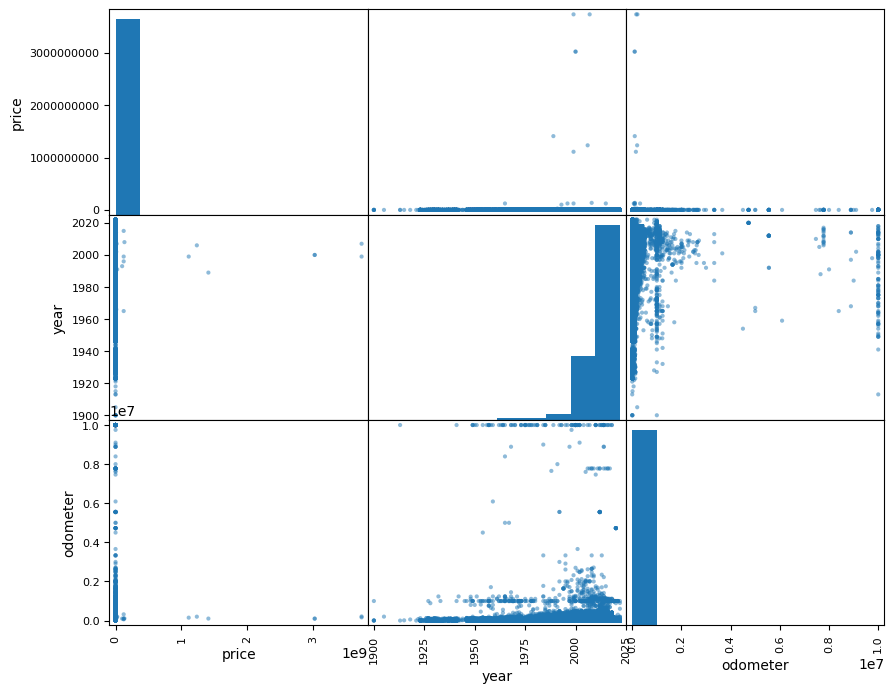

In [ ]:
pd.plotting.scatter_matrix(clear_df, figsize = (10, 8))
pass

### Поиск выбросов

Воспользуемся методом интерквартильных расстояний, для обнаружения выбросов и последующее их удаление

$Lim_max​=Q_3​+N_i​∗IQR$ </br>
$Lim_min=Q_1−N_i∗IQR$ </br>

где $Q_3$ — третий квартиль, $Q_1$ — первый квартиль, $IQR$ — интерквартильное расстояние, определяемое по формуле $IQR=Q_3−Q_1$​, a $N_i=1.5$ — заданное число интерквартильного размаха.

#### Признак price

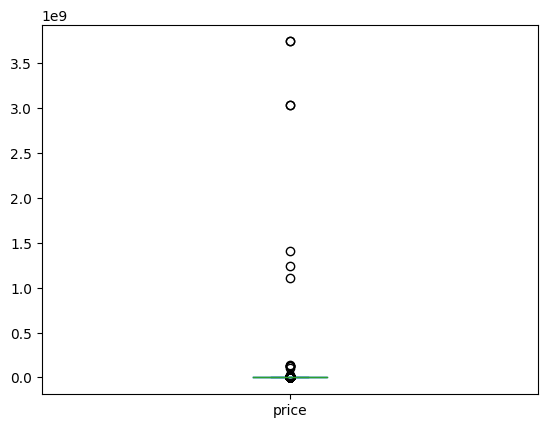

In [28]:
clear_df['price'].plot(kind='box')
pass

In [29]:
n = 1.5

q1 = clear_df['price'].quantile(0.25)
q3 = clear_df['price'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + n * iqr
lower_limit = q1 - n * iqr

In [30]:
clear_df = clear_df[(clear_df['price'] < upper_limit) & (clear_df['price'] > lower_limit)]

#### Признак odometer

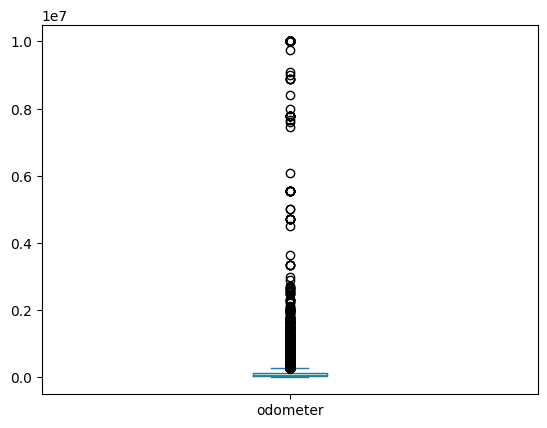

In [31]:
clear_df['odometer'].plot(kind='box')
pass

In [32]:
n = 1.5

q1 = clear_df['odometer'].quantile(0.25)
q3 = clear_df['odometer'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + n * iqr
lower_limit = q1 - n * iqr

In [33]:
clear_df = clear_df[(clear_df['odometer'] < upper_limit) & (clear_df['odometer'] > lower_limit)]

#### Результат


In [ ]:
clear_df.shape

(386276, 16)

В результате поиска выбросов, было выявленно и удалено 10058 строк их содержащих

In [ ]:
clear_df.sample(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,posting_date
188006,others,10999,2014,ford,fusion,unknown,unknown,gas,127197,clean,automatic,fwd,sedan,black,2014 Ford Fusion Titanium Offered by: GUAR...,2021-04-28 14:22:06+00:00
262826,others,5750,2007,ram,2500,unknown,6 cylinders,diesel,15000,clean,manual,4wd,unknown,unknown,Ford Super Duty F250 f350 f450 f550 Dodge ram ...,2021-05-01 12:35:19+00:00
95227,others,23590,2017,ram,others,good,6 cylinders,gas,42253,clean,other,unknown,pickup,black,Carvana is the safer way to buy a car During t...,2021-04-23 17:51:11+00:00
59854,others,7000,2004,dodge,others,like new,6 cylinders,gas,180000,clean,automatic,unknown,unknown,grey,"2004 Dodge Dakota, 3/4 Ton, 3.7L V6, ...",2021-05-01 06:07:59+00:00
22683,others,42995,2019,toyota,others,unknown,6 cylinders,gas,33078,clean,automatic,4wd,pickup,grey,2019 Toyota Tacoma LIFTED TRD SPORT Truck2019 ...,2021-04-16 22:40:16+00:00


## Бинаризация номинальных признаков





In [ ]:
clear_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386276 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   region        386276 non-null  category           
 1   price         386276 non-null  int64              
 2   year          386276 non-null  int64              
 3   manufacturer  386276 non-null  category           
 4   model         386276 non-null  category           
 5   condition     386276 non-null  category           
 6   cylinders     386276 non-null  category           
 7   fuel          386276 non-null  category           
 8   odometer      386276 non-null  int64              
 9   title_status  386276 non-null  category           
 10  transmission  386276 non-null  category           
 11  drive         386276 non-null  category           
 12  type          386276 non-null  category           
 13  paint_color   386276 non-null  category    

Бинаризируем следующие категориальные признаки

In [34]:
columns_for_enc = []

for col in clear_df.columns:
  if clear_df[col].dtype == 'category':
    columns_for_enc.append(col)

columns_for_enc

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'type',
 'paint_color']

In [35]:
from sklearn.preprocessing import OneHotEncoder

In [36]:
enc = OneHotEncoder(drop='if_binary', sparse=False)
enc.fit(clear_df[columns_for_enc])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='if_binary', sparse=False, sparse_output=False)

In [37]:
dummies = pd.DataFrame(enc.transform(clear_df[columns_for_enc]),
                       columns=enc.get_feature_names_out(), index=clear_df.index)
dummies.head()

,region_SF bay area,region_albuquerque,region_baltimore,region_bend,region_boise,region_cleveland,region_columbus,region_detroit metro,region_grand rapids,region_houston,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
clear_df = pd.concat((clear_df, dummies), axis=1).drop(columns_for_enc, axis=1)

In [ ]:
clear_df.head()

## Векторизация строковых признаков

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2b697496a9d6f39e0ccdd6402864dc12fe894ef56cce4b87bf179fa152094267
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import re
import pymorphy2

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import gensim.downloader as api

In [ ]:
def clean_text(text):
    text = text.lower()
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+\`]'
    text = re.sub(regular, '', text)

    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)

    return text

def normalize(text):
    text = word_tokenize(clean_text(text), language="english")

    res = []
    for token in text:
      if token not in stop_words:
          res.append(morphy.parse(token)[0].normal_form)
    return res

In [ ]:
morphy = pymorphy2.MorphAnalyzer()
word_vectors = api.load('glove-wiki-gigaword-50')
stop_words = stopwords.words("english")

nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
descriptions = clear_df['description']
desc = descriptions.iloc[0]

words = desc.split(' ')
print(words)

In [ ]:
word_vectors[words[4]]

array([ 0.53662  , -0.01189  , -0.24985  , -0.30536  ,  0.33947  ,
       -0.10958  , -0.44209  ,  0.0099388, -0.1815   ,  0.26726  ,
       -0.4314   ,  0.30656  , -0.68874  ,  0.044483 ,  0.11504  ,
        0.35505  ,  0.72325  , -0.2174   , -0.046881 , -0.63777  ,
       -0.12445  ,  0.45086  , -0.10405  ,  0.16283  ,  0.81381  ,
       -1.9463   , -0.39676  ,  0.29121  ,  0.90593  , -0.77543  ,
        3.6326   ,  0.49683  , -0.50868  , -0.40184  ,  0.0088379,
       -0.23548  , -0.19416  ,  0.43335  , -0.17993  , -0.15557  ,
       -0.34559  ,  0.01032  ,  0.04439  ,  0.33125  , -0.15722  ,
        0.28526  ,  0.14313  , -0.23625  ,  0.063342 ,  0.17774  ],
      dtype=float32)

In [39]:
clear_df = clear_df.drop_duplicates()

In [40]:
clear_df.reset_index(inplace=True, drop=True)

In [ ]:
clear_df['description'] = clear_df['description'].astype('object')

<ipython-input-61-9b745bb5342d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_df['description'] = clear_df['description'].astype('object')


In [ ]:
error_count = 0

for (index, desc) in clear_df['description'].items():
  norm = normalize(desc)
  vectors = []
  for token in norm:
    try:
        v = word_vectors[token]
        vectors.append(v.tolist())
    except:
      error_count += 1

  clear_df['description'][index] = np.array(vectors)

print("Errors count: ", error_count)

In [ ]:
clear_df.head()

## Построение моделей ИИ

In [41]:
import math

def analyse(y_predict_test, y_test):
  errors=[]
  y_test = y_test.tolist()
  for i in range(len(y_predict_test)):
    errors.append(min(1, math.floor(abs(y_predict_test[i]-y_test[i])/0.2)/((8.4-4.4)/2/0.2)))
  return 1-np.mean(errors)

### Разбиение данных на обучающуюю и тестовую выборки

In [42]:
from sklearn.model_selection import train_test_split

useless_col = ['description', 'posting_date', 'price']
X = clear_df.drop(useless_col, axis=1)
y = clear_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [43]:
N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(308981, 77246)

In [ ]:
X_train.shape

(309020, 167)

### Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
r_sq = lr_model.score(X_test, y_test)

In [ ]:
print('R2 score: ', r_sq)

R2 score:  0.4551814723704908


### K-Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(n_neighbors=5)
KNN.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
r_sq = KNN.score(X_test, y_test)
print('R2 score: ', r_sq)


#Обучение нейронной сети



In [ ]:
import numpy
import os
import pandas
import sklearn
import sklearn.model_selection
import sklearn.metrics
import warnings

from matplotlib import pyplot
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)

In [ ]:
%%time
linear_regression_model.fit(X_train, y_train)

CPU times: user 4min 24s, sys: 1.33 s, total: 4min 26s
Wall time: 4min 27s


SGDRegressor(tol=0.0001)

## Проверяем качество полученной нейронной сети

In [ ]:
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = sklearn.metrics.mean_squared_error(y_train, train_predictions)
test_mse = sklearn.metrics.mean_squared_error(y_test, test_predictions)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 2.6863290794851026e+35
Test MSE: 2.6894395597440238e+35


## Подбор параметров модели

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor

param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}
linear_regression_model = SGDRegressor(tol=.0001)
n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=3,
                                   scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Лучшие параметры: {}".format(random_search.best_params_))
print("Лучшая оценка MSE: {}".format(random_search.best_score_))


Лучшие параметры: {'eta0': 0.001}
Лучшая оценка MSE: -5.622836910124902e+33
